## Imports and Initialization

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier as rnd_frst
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier as dec_tr
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier as ada_boost
from sklearn.ensemble import GradientBoostingClassifier as grad_boost

import warnings
warnings.filterwarnings("ignore")


## Data Reading and Loading

In [2]:
def read_in_images(path, img_type):
    
    images = []
    
    for filename in os.listdir(path):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg") :
            image_path = os.path.join(path, filename)
            image = Image.open(image_path).convert("RGB")
            images.append({"type": img_type, "filename": filename, "image": image})
    
    return images

In [3]:
real_path = "RealArt/RealArt"
ai_path = "AiArtData"

real_images = read_in_images(real_path, "real")
ai_images = read_in_images(ai_path, "ai")

images = pd.DataFrame(real_images + ai_images)
images["type"] = images["type"].map({"real": 0, "ai": 1})
images.head(5)

,type,filename,image
0,0,3F302C18-1DA6-4372-8E313E2FF2CF4D86_source.png,<PIL.Image.Image image mode=RGB size=1570x1089...
1,0,images32.jpg,<PIL.Image.Image image mode=RGB size=275x183 a...
2,0,Van-Gogh-Self-Portrait-ft-min-pwoxk5den6j39ict...,<PIL.Image.Image image mode=RGB size=1140x500 ...
3,0,dog.jpg,<PIL.Image.Image image mode=RGB size=1200x800 ...
4,0,fox-937049_1920.jpg,<PIL.Image.Image image mode=RGB size=397x265 a...


### Image Transformation

In [11]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150, 150),interpolation=InterpolationMode.BICUBIC)
])

images["trans image"] = images["image"].apply(lambda x: img_transform(x))

## Dataset Preparation and Custom Dataset class

In [14]:
train, test = train_test_split(images, test_size = 0.3, random_state = 1)

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
   
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx, 3]
        label = self.dataframe.iloc[idx, 0]
        

        return image, label

train_custom = CustomDataset(train)
test_custom = CustomDataset(test)

loader_train = DataLoader(dataset = train_custom, batch_size = 50, shuffle = True)
load_test = DataLoader(dataset = test_custom, batch_size = 50, shuffle = False)

imgs, lbls = next(iter(loader_train))

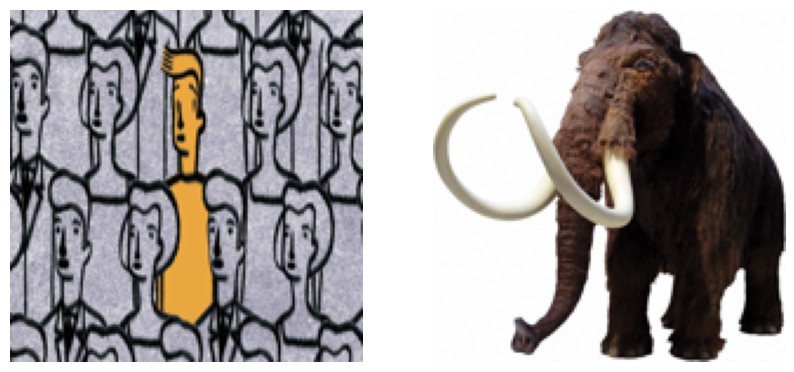

In [15]:
plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    img = imgs[i].permute(1, 2, 0).numpy() 
    img = img.clip(0, 1) 
    plt.imshow(img)
    plt.axis("off")
plt.show()


## Data Preparation for Model

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


loader_train = DataLoader(dataset=train_custom, batch_size=679, shuffle=True)
load_test = DataLoader(dataset=test_custom, batch_size=291, shuffle=False)
train_imgs, train_labels = next(iter(loader_train))
train_imgs = train_imgs.to(device)
train_labels = train_labels.to(device)


train_imgs = train_imgs.reshape((679, 3 * train_imgs.shape[2] * train_imgs.shape[3]))
test_imgs, test_labels = next(iter(load_test))
test_imgs = test_imgs.to(device)
test_labels = test_labels.to(device)


test_imgs = test_imgs.reshape((291, 3 * test_imgs.shape[2] * test_imgs.shape[3]))

train_imgs = train_imgs.cpu().numpy()
train_labels = train_labels.cpu().numpy()
test_imgs = test_imgs.cpu().numpy()
test_labels = test_labels.cpu().numpy()



# Exploration of Models and Hyperparameters

### Training & Evaluate Random Forest 

In [18]:
rf1 = rnd_frst(n_estimators=50)
rf1.fit(train_imgs, train_labels)
y_hat1 = rf1.predict(train_imgs)
y_hat_test = rf1.predict(test_imgs)
print("Testing score:", accuracy_score(test_labels, y_hat_test))
print("Training score:", accuracy_score(train_labels, y_hat1))


Testing score: 0.6735395189003437
Training score: 1.0


0.6597938144329897


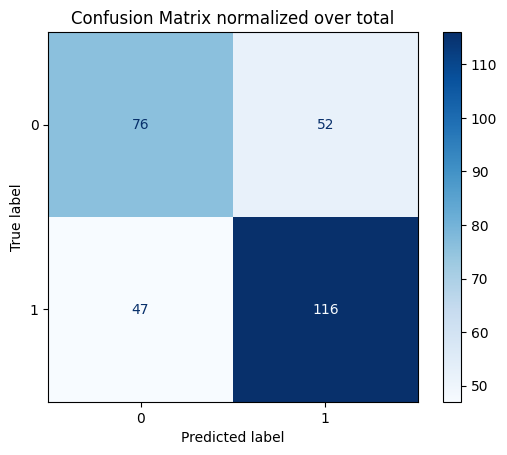

In [19]:
m = confusion_matrix(test_labels, y_hat_test)
disp = ConfusionMatrixDisplay.from_predictions(
     test_labels,
     y_hat_test,
     cmap=plt.cm.Blues,
     normalize=None
    )

print(accuracy_score(test_labels, y_hat_test))
disp.ax_.set_title('Confusion Matrix normalized over total');

## Hyperparameter Tuning 

**Random Forest Model**

In [19]:
rf = rnd_frst()
param_dist = {'n_estimators': np.random.randint(10,200,7),
              'max_depth': np.random.randint(1,20,7),
              "ccp_alpha":np.random.randint(0,1,5)}

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5) 


rand_search.fit(train_imgs,train_labels)
best_rf = rand_search.best_estimator_ 
print('Best hyperparameters:',  rand_search.best_estimator_ )

Best hyperparameters: RandomForestClassifier(ccp_alpha=np.int64(0), max_depth=np.int64(5),
                       n_estimators=np.int64(105))


**Gradient Boost Model**

In [ ]:
grad = grad_boost()
param_dist = {'n_estimators': np.random.randint(10,200,7),
              'max_depth': np.random.randint(1,20,7)}

rand_search = RandomizedSearchCV(grad, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5) 


rand_search.fit(train_imgs,train_labels)
best_rf3 = rand_search.best_estimator_ 
print('Best hyperparameters:',  rand_search.best_estimator_ )

**AdaBoost**

In [ ]:
ada = ada_boost()
param_dist = {'n_estimators': np.random.randint(10,200,7)}

rand_search = RandomizedSearchCV(ada, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5) 


rand_search.fit(train_imgs,train_labels)
best_rf2 = rand_search.best_estimator_ 
print('Best hyperparameters:',  rand_search.best_estimator_ )


### Finding optimal alpha parameter using Decision tree model

In [ ]:
model=dec_tr()
path= model.cost_complexity_pruning_path(train_imgs, train_labels)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
best_alpha = ccp_alphas[np.argmax(impurities)]
print("Best alpha:", best_alpha)

## Exploring Random Forest Model with Different Hyperparameters

#### n_estimators and max_depth parameters

In [21]:
#best parameters
y_hat2 = best_rf.predict(test_imgs)
y_hat_train2=best_rf.predict(train_imgs)
print("testing",accuracy_score(test_labels, y_hat2))
print("training",accuracy_score(train_labels, y_hat_train2))

testing 0.6701030927835051
training 1.0


In [22]:
model = rnd_frst(n_estimators=71,max_depth=9)  
model.fit(train_imgs, train_labels)
y_hat2 = model.predict(test_imgs)
y_hat_train2=model.predict(train_imgs)
print("testing",accuracy_score(test_labels, y_hat2))
print("training",accuracy_score(train_labels, y_hat_train2))

testing 0.6735395189003437
training 1.0


In [19]:
model = rnd_frst(n_estimators=49,max_depth=17)  
model.fit(train_imgs, train_labels)
y_hat2 = model.predict(test_imgs)
y_hat_train2=model.predict(train_imgs)
print("testing",accuracy_score(test_labels, y_hat2))
print("training",accuracy_score(train_labels, y_hat_train2))

testing 0.6804123711340206
training 1.0


In [ ]:
model = rnd_frst(n_estimators=49,max_depth=17,ccp_alpha=0.046)  
model.fit(train_imgs, train_labels)
y_hat2 = model.predict(test_imgs)
y_hat_train2=model.predict(train_imgs)
print("testing",accuracy_score(test_labels, y_hat2))
print("training",accuracy_score(train_labels, y_hat_train2))

In [ ]:
model2 = rnd_frst(ccp_alpha=0.046)  
model2.fit(train_imgs, train_labels)
y_hat3 = model2.predict(test_imgs)
y_hat_train3=model2.predict(train_imgs)
print("testing",accuracy_score(test_labels, y_hat3))
print("training",accuracy_score(train_labels, y_hat_train3))

## Exploring Gradient Boost Model with Different Hyperparameters

In [ ]:
#best parameters
y_hat4 = best_rf3.predict(test_imgs)
y_hat_train4=best_rf3.predict(train_imgs)
print("testing",accuracy_score(test_labels, y_hat4))
print("training",accuracy_score(train_labels, y_hat_train4))

In [ ]:
model_grad2 = grad_boost(n_estimators = 49,max_depth=17)
model_grad2.fit(train_imgs, train_labels)
y_hat = model_grad2.predict(test_imgs)
y_hat_train2=model_grad2.predict(train_imgs)
print("Testing",accuracy_score(test_labels, y_hat))
print("training",accuracy_score(train_labels,y_hat_train2))

In [ ]:
model_grad = grad_boost(n_estimators = 49,max_depth=17,ccp_alpha=0.046)
model_grad.fit(train_imgs, train_labels)
y_hat = model_grad.predict(test_imgs)
y_hat_train2=model_grad.predict(train_imgs)
print("Testing",accuracy_score(test_labels, y_hat))
print("training",accuracy_score(train_labels,y_hat_train2))

## AdaBoost

***Evaluating AdaBoost with Optimized Parameters***

In [ ]:
y_hat3 = best_rf2.predict(test_imgs)
y_hat_train3=best_rf2.predict(train_imgs)
print("testing",accuracy_score(test_labels, y_hat))
print("training",accuracy_score(train_labels, y_hat_train))

***AdaBoost with Custom Decision Tree Base Classifier***

In [ ]:
base_classifier = DecisionTreeClassifier(max_depth=17)
model_ada = AdaBoostClassifier(n_estimators=49)
model_ada.base_estimator_ = base_classifier
model_ada.fit(train_imgs, train_labels)
y_hat = model_ada.predict(test_imgs)
y_hat_train=model_ada.predict(train_imgs)
print("testing",accuracy_score(test_labels, y_hat))
print("training",accuracy_score(train_labels,y_hat_train))

# Confusion Matrix for the Optimized Models

testing 0.6769759450171822
training 1.0


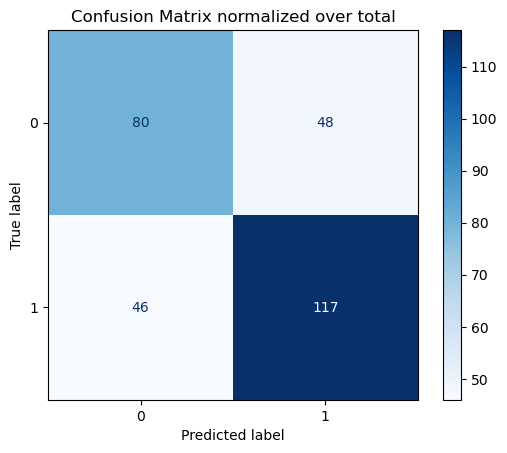

In [50]:
model_final = rnd_frst(n_estimators=49,max_depth=17)  
model_final.fit(train_imgs, train_labels)
y_hat2 = model_final.predict(test_imgs)
y_hat_train2=model_final.predict(train_imgs)


m = confusion_matrix(test_labels, y_hat2)
disp = ConfusionMatrixDisplay.from_predictions(
     test_labels,
     y_hat2,
     cmap=plt.cm.Blues,
     normalize=None
    )

disp.ax_.set_title('Confusion Matrix normalized over total');
print("testing",accuracy_score(test_labels, y_hat2))
print("training",accuracy_score(train_labels, y_hat_train2))



In [66]:
#Random forest using best hyperparameters and best alpha 
model_alpha = rnd_frst(n_estimators = 49, ccp_alpha =0.045,max_depth=17,random_state = 1)
model_alpha.fit(train_imgs, train_labels)
y_hat = model_alpha.predict(test_imgs)
accuracy_score(test_labels, y_hat)

0.6185567010309279

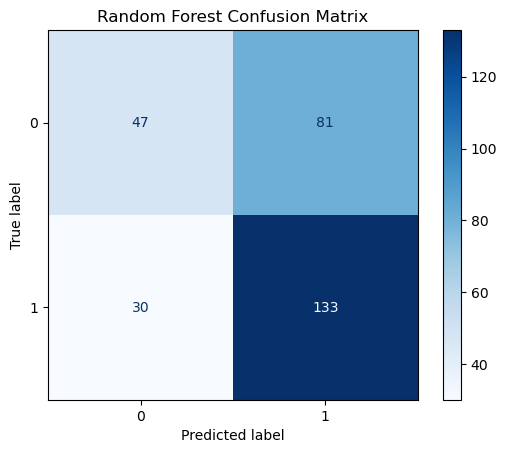

In [68]:
y_hat_3 = model_alpha.predict(test_imgs)
m = confusion_matrix(test_labels, y_hat_3)
disp = ConfusionMatrixDisplay.from_predictions(
     test_labels,
     y_hat_3,
     cmap=plt.cm.Blues,
     normalize=None
    )

#print(accuracy_score(test_labels, y_hat))
disp.ax_.set_title('Random Forest Confusion Matrix');